# **Assignment 1**: Computing the area of the Mandelbrot Set

Karolina Chlopicka, 15716546 <br>
Shania Sinha, 14379031 <br>
Salomé Poulain, 13955993

In [2]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
from scipy.stats import qmc  # For (Orthogonal) Latin Hypercube sampling
from joblib import Parallel, delayed

%matplotlib inline

## Problem 1: Mandelbrot Set

Creating and visualizing an example of the Mandelbrot set.

In [3]:
BOUNDING_BOX_X = (-2.5, 1.5)
BOUNDING_BOX_Y = (-2, 2)
BOUND = 2
RESOLUTION_POINTS = 500
POWER = 2
MAX_ITER = 100 # Maximum number of iterations to check for convergence when plotting Mandelbrot set
SEED = 42

COLORMAP = 'magma'

LITERARY_VALUE = 1.506591856 ####### idk

# COLOURS ??? maybe nice for the future 

In [4]:
def build_mandelbrot(
    X: np.ndarray, 
    Y: np.ndarray, 
    bound: float = BOUND,
    power: int = POWER, 
    max_iter: int = MAX_ITER
) -> List[List[int]]:
    """
    Compute the Mandelbrot set for given x and y ranges.

    Parameters:
        X (np.ndarray): Array of x values (real parts of complex plane).
        Y (np.ndarray): Array of y values (imaginary parts of complex plane).
        bound (float): Threshold for divergence in the Mandelbrot set.
        power (int): The exponent for complex power in Mandelbrot iteration.
        max_iter (int): Maximum number of iterations to compute per point.

    Returns:
        List[List[int]]: 2D list where each element represents the iteration count 
                         before divergence, or 0 if the point belongs to the set.
    """
    mandelbrot_set = []
    X, Y = np.meshgrid(X, Y)
    C = X + 1j * Y  # Create a grid of complex numbers
    Z = np.zeros_like(C, dtype=complex)
    div_iter = np.zeros(C.shape, dtype=int)  # Track divergence iteration counts

    # Iteratively compute the Mandelbrot set
    for i in range(1, max_iter + 1):
        mask = np.abs(Z) < bound
        Z[mask] = Z[mask] ** power + C[mask]  # Update only non-diverging points
        div_iter[mask & (np.abs(Z) >= bound)] = i  # Record when they diverge

    mandelbrot_set = div_iter.tolist()  # Convert to a list of lists
    return mandelbrot_set

In [5]:
def plot_mandelbrot(mandelbrot_set: List[List[int]]):
    """
    Plot the Mandelbrot set.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(mandelbrot_set, 
               cmap=COLORMAP, 
               extent=(BOUNDING_BOX_X[0], BOUNDING_BOX_X[1], 
                       BOUNDING_BOX_Y[0], BOUNDING_BOX_Y[1]))
    plt.colorbar()
    plt.title(f"Mandelbrot Set $z = z^{POWER} + c$")
    plt.xlabel("Real(c)")
    plt.ylabel("Imaginary(c)")
    plt.show()

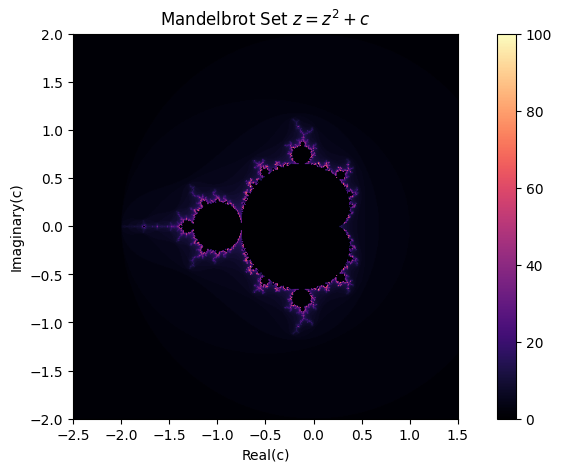

In [6]:
# Setting parameters
all_x = np.linspace(BOUNDING_BOX_X[0], BOUNDING_BOX_X[1], RESOLUTION_POINTS)
all_y = np.linspace(BOUNDING_BOX_Y[0], BOUNDING_BOX_Y[1], RESOLUTION_POINTS)

mandelbrot_set = build_mandelbrot(all_x, all_y)
plot_mandelbrot(mandelbrot_set)

## Problem 2: Investigate the convergence of $A_{i,s} \rightarrow A_M$

Investigating the area of the Mandelbrot set $A_M$ using Monte Carlo integration. $A_{i,s}$ denotes an estimate of an area, where $i$ refers to a number of iterations and $s$ refers to number of samples drawn.  

### 2.1 Implementing necessery functions to investigate the convergence

In [7]:
def _check_points_mandelbrot(
    X: np.ndarray, Y: np.ndarray) -> np.ndarray:
    """
    Check if points in a grid are within the Mandelbrot set.

    Parameters:
        X (np.ndarray): Array of x-coordinates (real parts of complex numbers).
        Y (np.ndarray): Array of y-coordinates (imaginary parts of complex numbers).
        bound (float): Threshold for divergence in the Mandelbrot set (default is 2.0).
        max_iter (int): Maximum number of iterations for checking divergence (default is 100).

    Returns:
        np.ndarray: Boolean array of the same shape as X and Y, where True indicates
                    that the point is in the Mandelbrot set (does not diverge within the
                    iteration limit), and False indicates divergence.
    """
    # Create the complex plane grid from X and Y values
    C = X + 1j * Y
    Z = np.zeros_like(C, dtype=complex)  
    mask = np.ones(C.shape, dtype=bool)  

    # Iteratively compute the Mandelbrot set
    for _ in range(MAX_ITER):
        Z[mask] = Z[mask] ** POWER + C[mask] 
        mask &= np.abs(Z) < BOUND            

    return mask

In [8]:
def monte_carlo_random(i: int, sample_size: int) -> np.ndarray:
    """
    Monte Carlo simulation to estimate the area of the Mandelbrot set.

    Parameters:
        i (int): Number of iterations.
        sample_size (int): Number of samples per iteration.
        bound (float): Threshold for divergence in the Mandelbrot set (default is 2.0).
        max_iter (int): Maximum number of iterations for checking divergence.

    Returns:
        np.ndarray: Array of estimated area of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    iterations = i
    size_iterations = np.zeros(iterations)

    for j in range(iterations):
        # Generate random points within the bounding rectangle
        x_coordinates = np.random.uniform(BOUNDING_BOX_X[0], BOUNDING_BOX_X[1], sample_size)
        y_coordinates = np.random.uniform(BOUNDING_BOX_Y[0], BOUNDING_BOX_Y[1], sample_size)

        # Check if the points are in the Mandelbrot set using the vectorized function
        mask = _check_points_mandelbrot(x_coordinates, y_coordinates)

        # Calculate the area estimation for this iteration
        points_in_set = np.count_nonzero(mask)  
        area_estimate = (points_in_set / sample_size) * area  

        # Store the result of this iteration
        size_iterations[j] = area_estimate
    
    return size_iterations


In [9]:
def _calculate_iteration_statistics(size_iterations: np.ndarray) -> Tuple[float, float]:
    """
    Calculate the mean and standard deviation of the given size iterations array.

    Parameters:
        size_iterations (np.ndarray): Array of area estimates from each Monte Carlo iteration.

    Returns:
        Tuple[float, float]: A tuple containing the mean and standard deviation.
    """
    mean = np.mean(size_iterations)
    std_dev = np.std(size_iterations)
    return mean, std_dev

In [ ]:
#  Testing the function
# monte_carlo_random(10000,1000)

Function to estimate the Mandelbrot set area over varying numbers of iterations

In [10]:
def monte_carlo_trajectory_iterations(
    sample_size: int, 
    start_iter: int, 
    end_iter: int, 
    measurements_amount: int,
    monte_carlo_method: Callable[[int, int], np.ndarray],
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a Monte Carlo convergence test to estimate the Mandelbrot set area and
    standard deviation over varying numbers of iterations.

    Parameters:
        sample_size (int): Number of samples per iteration.
        start_iter (int): Starting number of iterations.
        end_iter (int): Ending number of iterations.
        measurements_amount (int): Total number of different iteration counts to test.
        monte_carlo_method (Callable): Monte Carlo method function to use for estimation.
            The function should accept two arguments (iterations, sample_size) and return
            an array of area estimates.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - estimation_per_iteration (np.ndarray): Array of estimated areas per iteration count.
            - std_dev_per_iteration (np.ndarray): Array of standard deviations per iteration count.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_iterations = np.linspace(start_iter, end_iter, measurements_amount, dtype=int)
    estimation_per_iteration = np.zeros(len(number_of_iterations))  # Store estimated area
    std_dev_per_iteration = np.zeros(len(number_of_iterations))     # Store standard deviation

    # Define a function for parallelized computation of area estimates per iteration
    def compute_estimate(iterations):
        area_estimates = monte_carlo_method(iterations, sample_size)
        estimation, std_dev = _calculate_iteration_statistics(area_estimates)
        return estimation, std_dev

    # Parallelize across iteration counts
    results = Parallel(n_jobs=measurements_amount)(
        delayed(compute_estimate)(iterations) for iterations in number_of_iterations
    )

    # Store results into respective arrays
    for i, (estimation, std_dev) in enumerate(results):
        estimation_per_iteration[i] = estimation
        std_dev_per_iteration[i] = std_dev

    return estimation_per_iteration, std_dev_per_iteration

Function to estimate the Mandelbrot set area over varying numbers of samples

In [11]:
def monte_carlo_trajectory_samples(
    iteration: int, 
    start_sample: int, 
    end_sample: int, 
    measurements_amount: int,
    monte_carlo_method: Callable[[int, int], np.ndarray],
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform a Monte Carlo convergence test to estimate the Mandelbrot set area and
    standard deviation over varying numbers of samples.

    Parameters:
        iteration (int): Number of iterations performed for each sample size.
        start_sample (int): Starting number of samples.
        end_sample (int): Ending number of samples.
        measurements_amount (int): Total number of different sample counts to test.
        monte_carlo_method (Callable): Monte Carlo method function to use for estimation.
            The function should accept two arguments (iterations, sample_size) and return
            an array of area estimates.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - estimation_per_sample (np.ndarray): Array of estimated areas per sample count.
            - std_dev_per_sample(np.ndarray): Array of standard deviations per sample count.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_samples = np.linspace(start_sample, end_sample, measurements_amount, dtype=int)
    estimation_per_sample = np.zeros(len(number_of_samples))  # Store estimated area
    std_dev_per_sample = np.zeros(len(number_of_samples))     # Store standard deviation

    # Define a function for parallelized computation of area estimates per iteration
    def compute_estimate(sample):
        area_estimates = monte_carlo_method(iteration, sample)
        estimation, std_dev = _calculate_iteration_statistics(area_estimates)
        return estimation, std_dev

    # Parallelize across iteration counts
    results = Parallel(n_jobs=measurements_amount)(
        delayed(compute_estimate)(sample) for sample in number_of_samples
    )

    # Store results into respective arrays
    for i, (estimation, std_dev) in enumerate(results):
        estimation_per_sample[i] = estimation
        std_dev_per_sample[i] = std_dev

    return estimation_per_sample, std_dev_per_sample

Function to plot estimated Mandelbrot area over varing number of iterations

In [12]:
def plot_monte_carlo_methods(
    method_names: List[str], 
    method_results: List[Tuple[np.ndarray, np.ndarray]],
    start_iter: int,
    end_iter: int,
    measurements_amount: int,
    expected_value: float,
    plot_std: bool = False
) -> None:
    """
    Plot Monte Carlo convergence for different methods, showing both the estimated area, 
    the standard deviation around it (optional), and the difference in estimated area for each method.

    Parameters:
        method_names (List[str]): List of method names for labeling the plot.
        method_results (List[Tuple[np.ndarray, np.ndarray]]): List of tuples containing 
            the estimation and standard deviation arrays for each method.
        start_iter (int): Starting number of iterations.
        end_iter (int): Ending number of iterations.
        measurements_amount (int): Total number of different iteration counts to test.
        expected_value (float): The "literary" or expected value to compare against.
        plot_std (bool): Whether to plot standard deviation as a shaded region (default is False).

    Returns:
        None: This function plots the results directly.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_iterations = np.linspace(start_iter, end_iter, measurements_amount, dtype=int)

    # Set up the figure and subplots
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Loop over each method result and plot
    for method_name, (estimation, std_dev) in zip(method_names, method_results):
        # Plot the estimated area on the first subplot
        ax1.plot(number_of_iterations, estimation, label=method_name)
        
        # Optionally plot the standard deviation as a shaded region around the estimated area
        if plot_std:
            ax1.fill_between(
                number_of_iterations,
                estimation - std_dev,
                estimation + std_dev,
                alpha=0.2,
                label=f"{method_name} ± 1 Std Dev"
            )
        
        # Calculate the difference from the final estimated area (convergence reference)
        final_estimation = estimation[-1]  # Use the last estimation as the reference
        difference = np.abs(estimation[:-1] - final_estimation)  # Difference with the reference
        
        # Plot the difference in estimated area on the second subplot
        ax2.plot(number_of_iterations[:-1], difference, label=method_name)

    # Configure the first subplot (Estimated Area)
    ax1.set_xlabel("Number of Iterations")
    ax1.set_ylabel("Estimated Area of Mandelbrot Set")
    ax1.set_title("Estimated Area of Mandelbrot Set with Standard Deviation" if plot_std else "Estimated Area of Mandelbrot Set")
    ax1.grid(True)
    
    # Plot the expected (literary) value as a horizontal line
    ax1.axhline(y=expected_value, color='r', linestyle='--', label=f'Literary Value = {expected_value}')
    ax1.legend(title="Methods")

    # Configure the second subplot (Difference in Estimated Area)
    ax2.set_xlabel("Number of Iterations")
    ax2.set_ylabel("Difference relative to final estimated area")
    ax2.set_title("Difference in Estimated Area Convergence")
    ax2.grid(True)
    ax2.legend(title="Methods")

    # Display the plots with tight layout
    plt.tight_layout()
    plt.show()

Function to plot estimated area over varing number of samples 

In [13]:
def plot_monte_carlo_methods_sample(
    method_names: List[str], 
    method_results: List[Tuple[np.ndarray, np.ndarray]],
    start_sample: int,
    end_sample: int,
    measurements_amount: int,
    expected_value: float,
    plot_std: bool = False
) -> None:
    """
    Plot Monte Carlo convergence for different methods, showing both the estimated area, 
    the standard deviation around it (optional), and the difference in estimated area for each method.

    Parameters:
        method_names (List[str]): List of method names for labeling the plot.
        method_results (List[Tuple[np.ndarray, np.ndarray]]): List of tuples containing 
            the estimation and standard deviation arrays for each method.
        start_sample (int): Starting sample size.
        end_sample (int): Ending sample size.
        measurements_amount (int): Total number of different sample size counts to test.
        expected_value (float): The "literary" or expected value to compare against.
        plot_std (bool): Whether to plot standard deviation as a shaded region (default is False).

    Returns:
        None: This function plots the results directly.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_samples = np.linspace(start_sample, end_sample, measurements_amount, dtype=int)

    # Set up the figure and subplots
    figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Loop over each method result and plot
    for method_name, (estimation, std_dev) in zip(method_names, method_results):
        # Plot the estimated area on the first subplot
        ax1.plot(number_of_samples, estimation, label=method_name)
        
        # Optionally plot the standard deviation as a shaded region around the estimated area
        if plot_std:
            ax1.fill_between(
                number_of_samples,
                estimation - std_dev,
                estimation + std_dev,
                alpha=0.2,
                label=f"{method_name} ± 1 Std Dev"
            )
        
        # Calculate the difference from the final estimated area (convergence reference)
        final_estimation = estimation[-1]  # Use the last estimation as the reference
        difference = np.abs(estimation[:-1] - final_estimation)  # Difference with the reference
        
        # Plot the difference in estimated area on the second subplot
        ax2.plot(number_of_samples[:-1], difference, label=method_name)

    # Configure the first subplot (Estimated Area)
    ax1.set_xlabel("Sample size")
    ax1.set_ylabel("Estimated Area of Mandelbrot Set")
    ax1.set_title("Estimated Area of Mandelbrot Set with Standard Deviation" if plot_std else "Estimated Area of Mandelbrot Set")
    ax1.grid(True)
    
    # Plot the expected (literary) value as a horizontal line
    ax1.axhline(y=expected_value, color='r', linestyle='--', label=f'Literary Value = {expected_value}')
    ax1.legend(title="Methods")

    # Configure the second subplot (Difference in Estimated Area)
    ax2.set_xlabel("Sample size")
    ax2.set_ylabel("Difference relative to final estimated area")
    ax2.set_title("Difference in Estimated Area Convergence")
    ax2.grid(True)
    ax2.legend(title="Methods")

    # Display the plots with tight layout
    plt.tight_layout()
    plt.show()

In [14]:
def plot_monte_carlo_trajectory_samples(
    method_names: List[str], 
    method_results: List[Tuple[np.ndarray, np.ndarray]],
    start_sample: int,
    end_sample: int,
    measurements_amount: int,
    expected_value: float,
    plot_std: bool = False
) -> None:
    """
    Plot Monte Carlo convergence difference relative to the expected (literary) value for each sample size,
    with standard deviation shown as a shaded region if desired.

    Parameters:
        method_names (List[str]): List of method names for labeling the plot.
        method_results (List[Tuple[np.ndarray, np.ndarray]]): List of tuples containing 
            the estimation and standard deviation arrays for each method.
        start_sample (int): Starting number of sample size.
        end_sample (int): Ending number of sample size.
        measurements_amount (int): Total number of different sample size counts to test.
        expected_value (float): The "literary" or expected value to compare against.
        plot_std (bool): Whether to plot standard deviation as a shaded region (default is False).
        
    Returns:
        None: This function plots the results directly.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_samples = np.linspace(start_sample, end_sample, measurements_amount, dtype=int)

    # Set up the figure
    plt.figure(figsize=(10, 6))

    # Loop over each method result and plot
    for method_name, (estimation, std_dev) in zip(method_names, method_results):
        # Calculate the difference from the expected (literary) value
        difference = np.abs(estimation - expected_value)

        # Plot the convergence difference relative to the expected (literary) value
        plt.plot(number_of_samples, difference, label=method_name)
        
        # Optionally plot the standard deviation as a shaded region around the difference
        if plot_std:
            plt.fill_between(
                number_of_samples,
                difference - std_dev,
                difference + std_dev,
                alpha=0.2,
                label=f"{method_name} ± 1 Std Dev"
            )

    # Configure the plot
    plt.xlabel("Number of Samples")
    plt.ylabel("Difference from Expected Value")
    plt.title("Convergence Difference Relative to Expected Value" + (" with Standard Deviation" if plot_std else ""))
    plt.legend(title="Methods")
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

## Problem 3: Different Sampling Methods

Explore different sampling methods. Namely:
1. Pure random sampling
2. Latin Hypercube sampling
3. Orthogonal sampling

### 3.1: Latin Hypercube

In [15]:
def monte_carlo_lhs(iterations, sample_size):
    """
    Monte Carlo simulation using Latin Hypercube Sampling (LHS) to estimate the Mandelbrot set area.
    
    Parameters:
        iterations (int): Number of iterations.
        sample_size (int): Number of samples per iteration.

    Returns:
        np.ndarray: Array of estimated area of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    size_iterations = np.zeros(iterations)

    # Initialize Latin Hypercube Sampler
    sampler = qmc.LatinHypercube(d=2, seed=SEED)
    
    for j in range(iterations):
        # Generate Latin Hypercube samples within the unit cube [0, 1]^2
        samples = sampler.random(n=sample_size)

        # Scale samples to the region bounds
        x_coordinates = samples[:, 0] * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) + BOUNDING_BOX_X[0]
        y_coordinates = samples[:, 1] * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) + BOUNDING_BOX_Y[0]

        # Check if points are in the Mandelbrot set
        mask = _check_points_mandelbrot(x_coordinates, y_coordinates)

        # Calculate the area estimate for this iteration
        points_in_set = np.count_nonzero(mask)
        area_estimate = (points_in_set / sample_size) * area
        size_iterations[j] = area_estimate

    return size_iterations

### 3.2: Orthogonal

In [ ]:
def monte_carlo_oa_lhs(iterations, sample_size):
    """
    Monte Carlo simulation using Orthogonal Array Latin Hypercube Sampling (LHS) to estimate the Mandelbrot set area.
    
    Parameters:
        iterations (int): Number of iterations.
        sample_size (int): Number of samples per iteration.

    Returns:
        np.ndarray: Array of estimated area of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    size_iterations = np.zeros(iterations)

    # Initialize O-A Latin Hypercube Sampler (need scipy version >= 1.10.0)
    sampler = qmc.LatinHypercube(d=2, strength=2, seed=SEED)
    
    for j in range(iterations):
        # Generate ortho-array Latin Hypercube samples
        samples = sampler.random(n=sample_size)

        # Scale samples to the region bounds
        x_coordinates = samples[:, 0] * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) + BOUNDING_BOX_X[0]
        y_coordinates = samples[:, 1] * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) + BOUNDING_BOX_Y[0]

        # Check if points are in the Mandelbrot set
        mask = _check_points_mandelbrot(x_coordinates, y_coordinates)

        # Calculate the area estimate for this iteration
        points_in_set = np.count_nonzero(mask)
        area_estimate = (points_in_set / sample_size) * area
        size_iterations[j] = area_estimate

    return size_iterations

### 3.3: Comparison of different sampling methods

Function to compare estimated area of Mandelbrot set for different sampling methods - over varying iterations

In [18]:
def plot_monte_carlo_convergence_difference_iterations(
    method_names: List[str], 
    method_results: List[Tuple[np.ndarray, np.ndarray]],
    start_iter: int,
    end_iter: int,
    total_iterations: int,
    expected_value: float,
    plot_std: bool = False
) -> None:
    """
    Plot Monte Carlo convergence difference relative to the expected (literary) value for each iteration,
    with standard deviation shown as a shaded region if desired.

    Parameters:
        method_names (List[str]): List of method names for labeling the plot.
        method_results (List[Tuple[np.ndarray, np.ndarray]]): List of tuples containing 
            the estimation and standard deviation arrays for each method.
        start_iter (int): Starting number of iterations.
        end_iter (int): Ending number of iterations.
        total_iterations (int): Total number of different iteration counts to test.
        expected_value (float): The "literary" or expected value to compare against.
        plot_std (bool): Whether to plot standard deviation as a shaded region (default is False).
        
    Returns:
        None: This function plots the results directly.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_iterations = np.linspace(start_iter, end_iter, total_iterations, dtype=int)

    # Set up the figure
    plt.figure(figsize=(10, 6))

    # Loop over each method result and plot
    for method_name, (estimation, std_dev) in zip(method_names, method_results):
        # Calculate the difference from the expected (literary) value
        difference = np.abs(estimation - expected_value)

        # Plot the convergence difference relative to the expected (literary) value
        plt.plot(number_of_iterations, difference, label=method_name)
        
        # Optionally plot the standard deviation as a shaded region around the difference
        if plot_std:
            plt.fill_between(
                number_of_iterations,
                difference - std_dev,
                difference + std_dev,
                alpha=0.2,
                label=f"{method_name} ± 1 Std Dev"
            )

    # Configure the plot
    plt.xlabel("Number of Iterations")
    plt.ylabel("Difference from Expected Value")
    plt.title("Convergence Difference Relative to Expected Value" + (" with Standard Deviation" if plot_std else ""))
    plt.legend(title="Methods")
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


Function to compare estimated area of Mandelbrot set for different sampling methods - over varying sample sizes

In [19]:
def plot_monte_carlo_convergence_difference_samples(
    method_names: List[str], 
    method_results: List[Tuple[np.ndarray, np.ndarray]],
    start_sample: int,
    end_sample: int,
    total_samples: int,
    expected_value: float,
    plot_std: bool = False
) -> None:
    """
    Plot Monte Carlo convergence difference relative to the expected (literary) value for each sample size,
    with standard deviation shown as a shaded region if desired.

    Parameters:
        method_names (List[str]): List of method names for labeling the plot.
        method_results (List[Tuple[np.ndarray, np.ndarray]]): List of tuples containing 
            the estimation and standard deviation arrays for each method.
        start_sample (int): Starting number of samples.
        end_sample (int): Ending number of samples.
        total_samples (int): Total number of different sample size counts to test.
        expected_value (float): The "literary" or expected value to compare against.
        plot_std (bool): Whether to plot standard deviation as a shaded region (default is False).
        
    Returns:
        None: This function plots the results directly.
    """
    # Generate an array of iteration counts between start_iter and end_iter
    number_of_iterations = np.linspace(start_sample, end_sample, total_samples, dtype=int)

    # Set up the figure
    plt.figure(figsize=(10, 6))

    # Loop over each method result and plot
    for method_name, (estimation, std_dev) in zip(method_names, method_results):
        # Calculate the difference from the expected (literary) value
        difference = np.abs(estimation - expected_value)

        # Plot the convergence difference relative to the expected (literary) value
        plt.plot(number_of_iterations, difference, label=method_name)
        
        # Optionally plot the standard deviation as a shaded region around the difference
        if plot_std:
            plt.fill_between(
                number_of_iterations,
                difference - std_dev,
                difference + std_dev,
                alpha=0.2,
                label=f"{method_name} ± 1 Std Dev"
            )

    # Configure the plot
    plt.xlabel("Number of Samples")
    plt.ylabel("Difference from Expected Value")
    plt.title("Convergence Difference Relative to Expected Value" + (" with Standard Deviation" if plot_std else ""))
    plt.legend(title="Methods")
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()

### Calculating and plotting the results for Problem 2 and Problem 3

Estimating the reference number $A_M = A_{i_{max}, s_{max}}$ - experiment 

In [20]:
A_M_list = []
for n in (100,200,300,400,500):
    result = monte_carlo_trajectory_iterations(n,1,100,1, monte_carlo_random)
    A_M_list.append(result)
    print(result)
print(A_M_list)

(array([1.44]), array([0.]))
(array([1.68]), array([0.]))
(array([1.38666667]), array([0.]))
(array([2.16]), array([0.]))
(array([1.504]), array([0.]))
[(array([1.44]), array([0.])), (array([1.68]), array([0.])), (array([1.38666667]), array([0.])), (array([2.16]), array([0.])), (array([1.504]), array([0.]))]


In [21]:
A_M = monte_carlo_trajectory_iterations(10000,10000,10000,1, monte_carlo_random)


In [ ]:
A_M_max = A_M[0]

### Plotting the convergence over varing iterations and varing sample sizes - random sampling 

(Option 1, constant variable kept at $\frac{1}{2} * (value_{max})$)

In [150]:
result_iteration_random = monte_carlo_trajectory_iterations(5000,100,10000,50, monte_carlo_random)

result_sample_random = monte_carlo_trajectory_samples(5000,100,10000,50,monte_carlo_random)

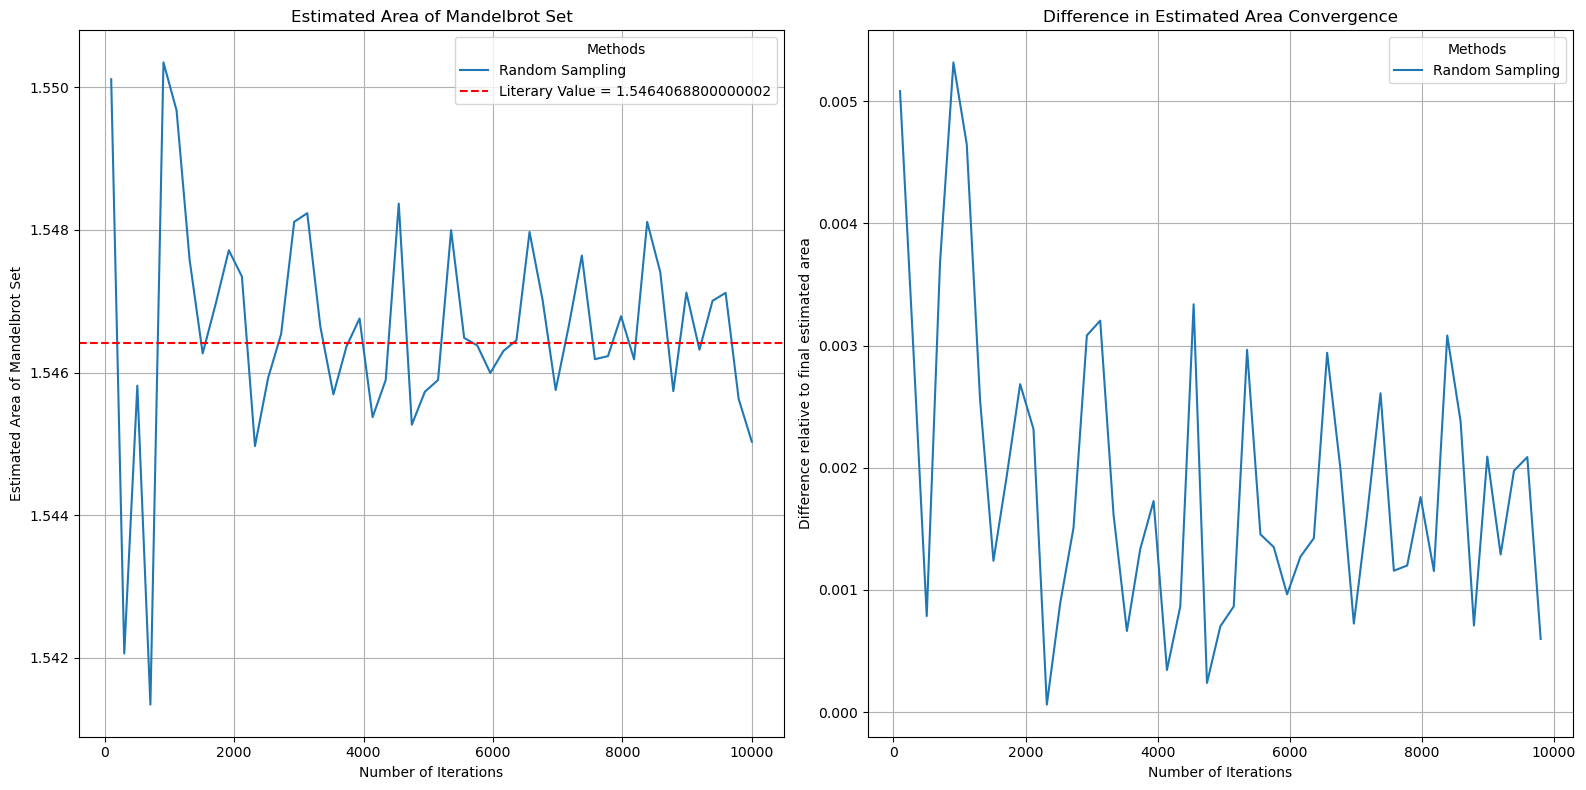

In [ ]:
plot_monte_carlo_methods(["Random Sampling"],[result_iteration_random],100,10000,50,A_M_max)

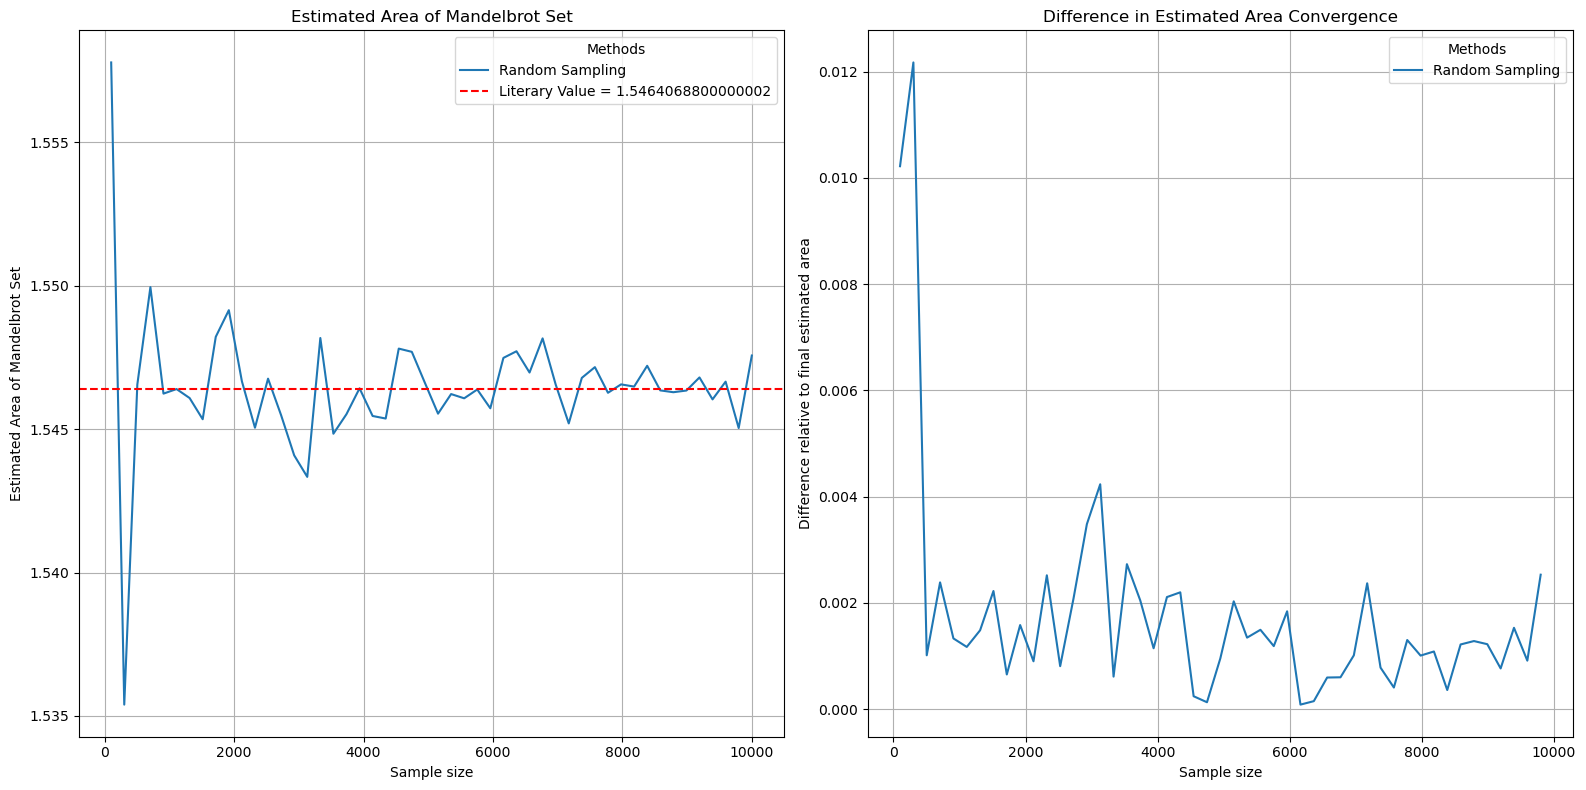

In [ ]:
plot_monte_carlo_methods_sample(["Random Sampling"],[result_sample_random],100,10000,50,A_M_max)

(Option 2 - constant variable kept at $\frac{1}{10} * (value_{max})$)

In [162]:
result_iteration_random = monte_carlo_trajectory_iterations(1000,100,10000,50, monte_carlo_random)

result_sample_random = monte_carlo_trajectory_samples(1000,100,10000,50,monte_carlo_random)

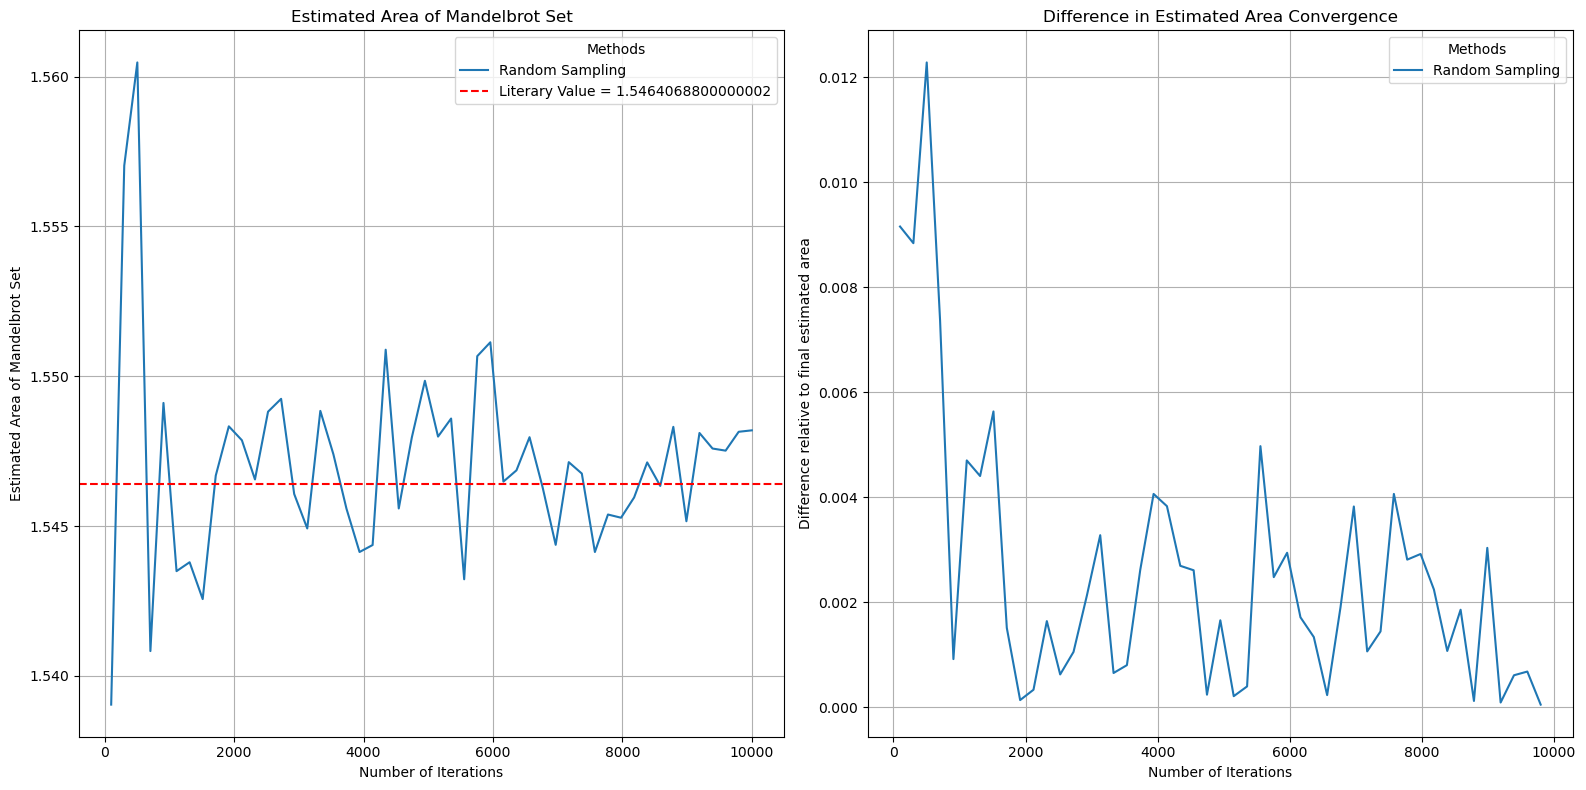

In [ ]:
plot_monte_carlo_methods(["Random Sampling"],[result_iteration_random],100,10000,50,A_M_max)

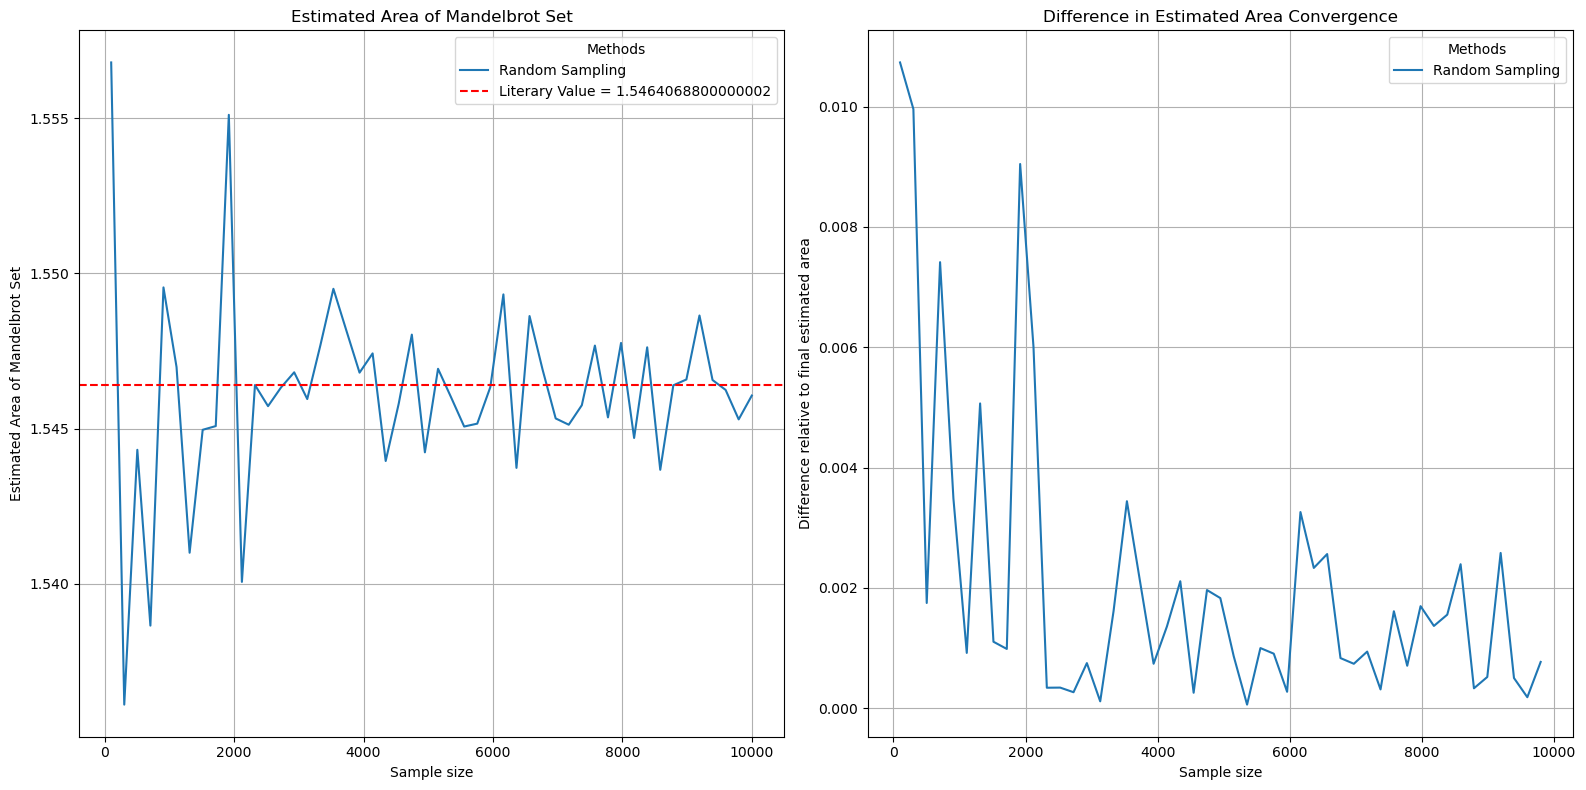

In [ ]:
plot_monte_carlo_methods_sample(["Random Sampling"],[result_sample_random],100,10000,50,A_M_max)

### Plotting the convergence over varing iterations and varing sample sizes - Latin Hypercube Sampling 

(Option 2 - constant variable kept at $\frac{1}{10} * (value_{max})$)

In [ ]:
result_iteration_lhs = monte_carlo_trajectory_iterations(1000,100,10000,50, monte_carlo_lhs)

In [169]:
result_samples_lhs = monte_carlo_trajectory_samples(1000,100,10000,50, monte_carlo_lhs)

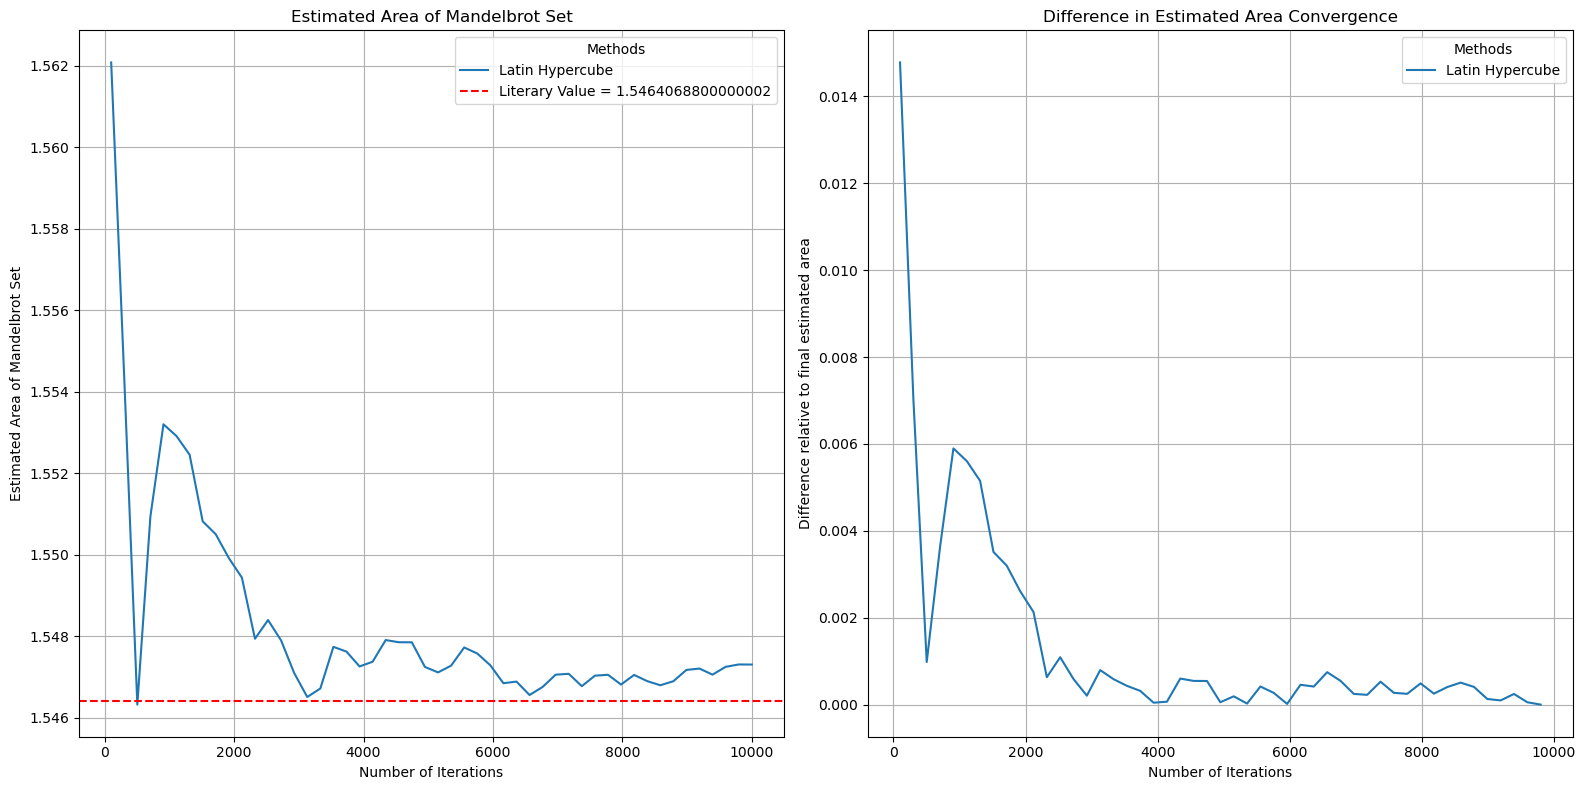

In [ ]:
plot_monte_carlo_methods(["Latin Hypercube"],[result_iteration_lhs],100,10000,50,A_M_max)

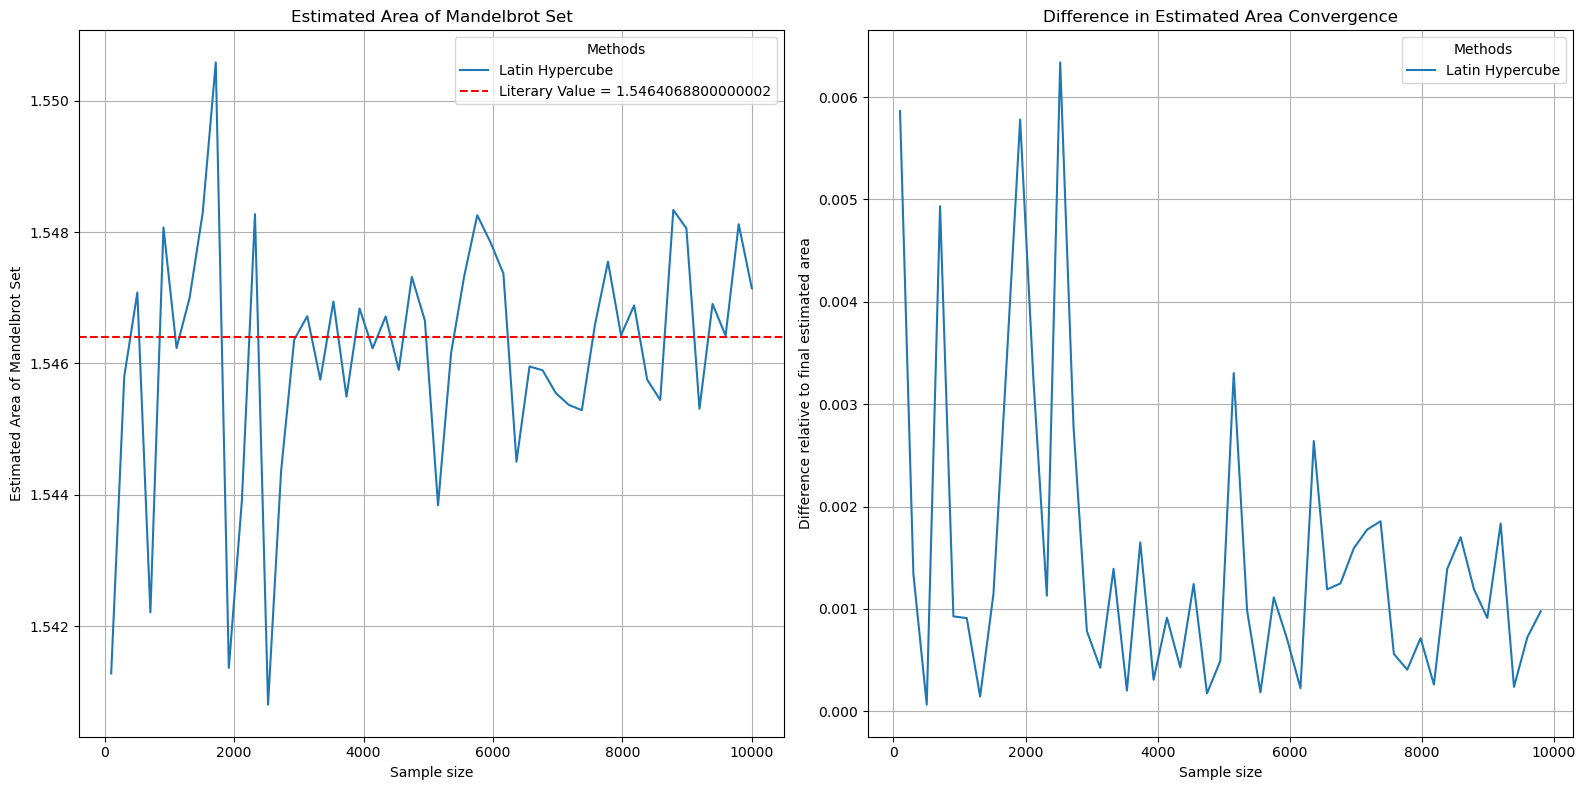

In [170]:
plot_monte_carlo_methods_sample(["Latin Hypercube"],[result_samples_lhs],100,10000,50,A_M)

### Plotting the convergence over varing iterations and varing sample sizes - Orthogonal Sampling 

Sample size: the sample size must be the square of a prime number

In [36]:
result_iteration_oa_lhs = monte_carlo_trajectory_iterations(169,100,5000,20, monte_carlo_oa_lhs)

In [ ]:
# TODO: need to define specific range of samples for OA-LHS
# result_samples_oa_lhs = monte_carlo_trajectory_samples(1000,100,10000,50, monte_carlo_oa_lhs)

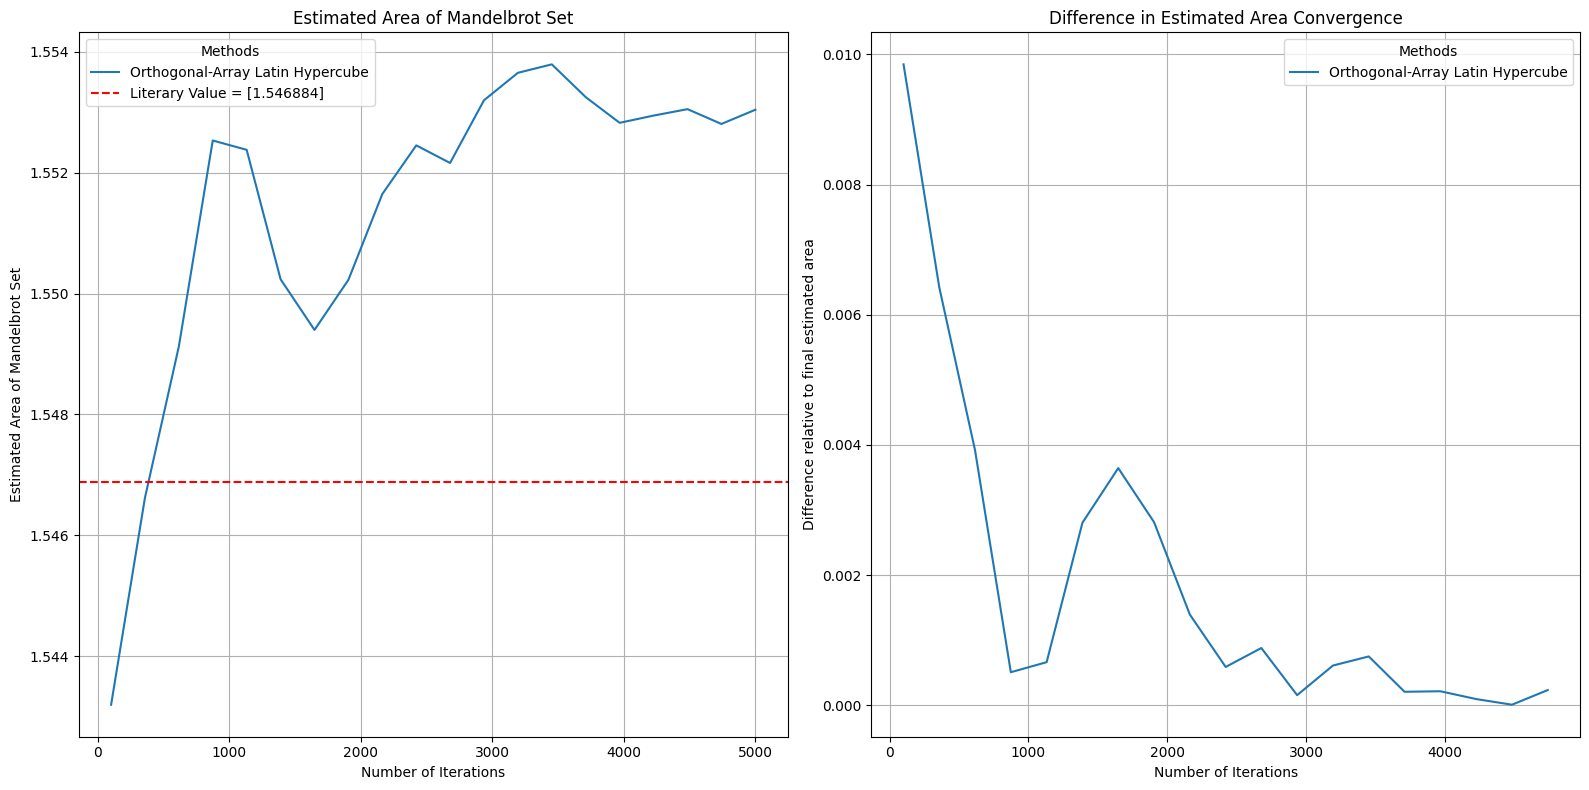

In [37]:
plot_monte_carlo_methods(["Orthogonal-Array Latin Hypercube"],[result_iteration_oa_lhs],100,5000,20,A_M_max)

In [ ]:
# TODO: need to define specific range of samples for OA-LHS
# plot_monte_carlo_methods_sample(["Orthogonal-Array Latin Hypercube"],[result_iteration_oa_lhs],100,10000,50,A_M)

In [ ]:
# TODO: use squares of these values for the expected value
primes_25 = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101]

### Comparing all sampling methods over varing number of iterations

In [ ]:
# Define parameters
sample_size = 5000
start_iter = 100
end_iter = 10000
measurements_amount = 50

# Define method names and results
methods = [monte_carlo_random, monte_carlo_lhs, monte_carlo_oa_lhs]  
method_names = ['Random Sampling', 'Latin Hypercube Sampling', 'Orthogonal Array Latin Hypercube Sampling']

# Calculate results for each method
results_iteration_all = [monte_carlo_trajectory_iterations(sample_size, start_iter, end_iter, measurements_amount, method) for method in methods]

### Comparing all sampling methods over varing sample sizes

In [ ]:
# Define parameters
iteration = 5000
start_sample = 100
end_sample = 10000
measurements_amount = 50

# Define method names and results
methods = [monte_carlo_random, monte_carlo_lhs, monte_carlo_oa_lhs]  
method_names = ['Random Sampling', 'Latin Hypercube Sampling', 'Orthogonal Array Latin Hypercube Sampling']

# Calculate results for each method
results_sample_all = [monte_carlo_trajectory_samples(iteration, start_sample, end_sample, measurements_amount, method) for method in methods]

Plotting the result

## Problem 4: Improvements to Monte Carlo Convergence Rate

Formulate and test a method to further improve the convergence rate of the Monte
Carlo approach.

In [38]:
def monte_carlo_stratified(iterations, sample_size, num_strata=10):
    """
    Monte Carlo simulation using Stratified Sampling to estimate the Mandelbrot set area.
    
    Parameters:
        iterations (int): Number of iterations.
        sample_size (int): Number of samples per iteration.
        num_strata (int): Number of strata along each axis (creates a grid of num_strata^2 cells).

    Returns:
        np.ndarray: Array of estimated areas of the Mandelbrot set for each iteration.
    """
    area = (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0])
    size_iterations = np.zeros(iterations)
    stratum_size = sample_size // (num_strata ** 2)  # Samples per stratum

    for j in range(iterations):
        samples_x = []
        samples_y = []

        # Generate stratified samples
        for i in range(num_strata):
            for k in range(num_strata):
                # Stratum bounds
                x_min = BOUNDING_BOX_X[0] + i * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) / num_strata
                x_max = BOUNDING_BOX_X[0] + (i + 1) * (BOUNDING_BOX_X[1] - BOUNDING_BOX_X[0]) / num_strata
                y_min = BOUNDING_BOX_Y[0] + k * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) / num_strata
                y_max = BOUNDING_BOX_Y[0] + (k + 1) * (BOUNDING_BOX_Y[1] - BOUNDING_BOX_Y[0]) / num_strata

                # Sample points uniformly within the stratum
                samples_x.append(np.random.uniform(x_min, x_max, stratum_size))
                samples_y.append(np.random.uniform(y_min, y_max, stratum_size))

        # Flatten arrays
        samples_x = np.concatenate(samples_x)
        samples_y = np.concatenate(samples_y)

        # Check if points are in the Mandelbrot set
        mask = _check_points_mandelbrot(samples_x, samples_y)

        # Calculate the area estimate for this iteration
        points_in_set = np.count_nonzero(mask)
        area_estimate = (points_in_set / sample_size) * area
        size_iterations[j] = area_estimate

    return size_iterations

In [39]:
# TODO: plot results from this function
result_iteration_stratified = monte_carlo_trajectory_iterations(1000,100,10000,50, monte_carlo_stratified)

KeyboardInterrupt: 